In [1]:
from __future__ import print_function

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

#import aparent.visualization as vis

#from aparent_predictor import *


In [2]:
#Load APADB Data and filter on targeted genes

#genes = ['RUNX1', 'CEBPA', 'GATA2', 'ANKRD26', 'DDX41', 'ETV6', 'PTEN', 'BRCA1', 'BRCA2', 'TP53', 'APC', 'ATM', 'PALB2', 'MSH2', 'MLH1', 'MSH6', 'PMS2', 'MUTYH']

polyadb_df = pd.read_csv('polyadb_processed.csv', sep=',')

#polyadb_df = polyadb_df.loc[polyadb_df['gene'].isin(genes)].reset_index(drop=True).copy()
polyadb_df = polyadb_df.loc[((~polyadb_df['gene'].isnull()) & (polyadb_df['gene'] != 'na')) & (polyadb_df['pas'] != -1)].reset_index(drop=True).copy()

print('len(polyadb_df) = ' + str(len(polyadb_df)))


len(polyadb_df) = 175451


In [3]:
#Process PolyaDB data

polyadb_df_minus = polyadb_df.query("strand == '-'").copy().reset_index(drop=True)
polyadb_df_plus = polyadb_df.query("strand == '+'").copy().reset_index(drop=True)

polyadb_df_minus = polyadb_df_minus.sort_values(by='pas_pos', ascending=False).copy().reset_index(drop=True)
polyadb_df_plus = polyadb_df_plus.sort_values(by='pas_pos', ascending=True).copy().reset_index(drop=True)

new_gene_id_list_plus = []
sitenum_list_plus = []
gene_id_dict = {}
for _, row in polyadb_df_plus.iterrows() :

    gene = row['gene']

    if gene not in gene_id_dict :
        gene_id_dict[gene] = 0

    gene_id_dict[gene] += 1

    new_gene_id_list_plus.append(gene + "." + str(gene_id_dict[gene]))
    sitenum_list_plus.append(gene_id_dict[gene])

polyadb_df_plus['gene_id'] = new_gene_id_list_plus
polyadb_df_plus['sitenum'] = sitenum_list_plus

new_gene_id_list_minus = []
sitenum_list_minus = []
gene_id_dict = {}
for _, row in polyadb_df_minus.iterrows() :

    gene = row['gene']

    if gene not in gene_id_dict :
        gene_id_dict[gene] = 0

    gene_id_dict[gene] += 1

    new_gene_id_list_minus.append(gene + "." + str(gene_id_dict[gene]))
    sitenum_list_minus.append(gene_id_dict[gene])

polyadb_df_minus['gene_id'] = new_gene_id_list_minus
polyadb_df_minus['sitenum'] = sitenum_list_minus

polyadb_df = pd.concat([polyadb_df_plus, polyadb_df_minus])

polyadb_df = polyadb_df.sort_values(by=['gene', 'sitenum'], ascending=True).reset_index(drop=True).copy()

In [4]:
#Get CausalDB metadata

causaldb_meta_df = pd.read_csv("causaldb_credible_set/causaldb_meta_info_v1.txt", sep='\t')


In [5]:
#Load cached causaldb dataframes (already intersected against predictions)

variant_df_gwas = pd.read_csv("aparent_resnet_variant_predictions_polyadb_no_sequences_causaldb_no_cutoff.csv", sep='\t')
variant_df_gwas_noncausal = pd.read_csv("aparent_resnet_variant_predictions_polyadb_no_sequences_noncausaldb_no_cutoff.csv", sep='\t')


In [6]:
#Drop duplicates for partially overlapping annotated PASs and add additional fields

variant_df_gwas['rsID'] = "rs" + variant_df_gwas['rsID'].astype(int).astype(str)

variant_df_gwas['delta_logodds_77_127_abs'] = np.abs(variant_df_gwas['delta_logodds_77_127'])

variant_df_gwas['rel_var_position'] = -1
variant_df_gwas.loc[variant_df_gwas['strand'] == '+', 'rel_var_position'] = variant_df_gwas['var_position'] - (variant_df_gwas['pas_pos'] - 70 + 1)
variant_df_gwas.loc[variant_df_gwas['strand'] == '-', 'rel_var_position'] = ((variant_df_gwas['pas_pos'] - (205 - 70)) + 205) - variant_df_gwas['var_position']

variant_df_gwas['alt_usage'] = 1. / (1. + 1. / ((np.clip(variant_df_gwas['native_usage'], 1e-7, 1. - 1e-7) / (1. - np.clip(variant_df_gwas['native_usage'], 1e-7, 1. - 1e-7))) * np.exp(variant_df_gwas['delta_logodds_0_205'])))
variant_df_gwas['delta_usage'] = variant_df_gwas['alt_usage'] - variant_df_gwas['native_usage']

variant_df_gwas['alt_usage_77_127'] = 1. / (1. + 1. / ((np.clip(variant_df_gwas['native_usage'], 1e-7, 1. - 1e-7) / (1. - np.clip(variant_df_gwas['native_usage'], 1e-7, 1. - 1e-7))) * np.exp(variant_df_gwas['delta_logodds_77_127'])))
variant_df_gwas['delta_usage_77_127'] = variant_df_gwas['alt_usage_77_127'] - variant_df_gwas['native_usage']

polyadb_df_unique = polyadb_df.drop_duplicates(subset=["gene_id"], keep='first').copy().reset_index(drop=True)
polyadb_df_unique['padb_join_id'] = polyadb_df_unique['chrom'] + "_" + polyadb_df_unique['pas_pos'].astype(str) + "_" + polyadb_df_unique['strand']
variant_df_gwas['padb_join_id'] = variant_df_gwas['chrom'] + "_" + variant_df_gwas['pas_pos'].astype(str) + "_" + variant_df_gwas['strand']

variant_df_gwas = variant_df_gwas.join(polyadb_df_unique[['padb_join_id', 'pas']].set_index("padb_join_id"), on='padb_join_id', how='inner').copy().reset_index(drop=True)

variant_df_gwas['target_rel_var_position'] = np.abs(90 - variant_df_gwas['rel_var_position'])
variant_df_gwas['target_delta_logodds_77_127_abs'] = -variant_df_gwas['delta_logodds_77_127_abs']
variant_df_gwas = variant_df_gwas.sort_values(by=['target_rel_var_position', 'target_delta_logodds_77_127_abs'], ascending=True).drop_duplicates(subset=['causaldb_join_id', 'meta_id'], keep='first').copy().reset_index(drop=True)
#variant_df_gwas['pas'] = -1. * variant_df_gwas['pas']
#variant_df_gwas = variant_df_gwas.sort_values(by=["pas", 'delta_logodds_77_127_abs'], ascending=False).drop_duplicates(subset=['causaldb_join_id', 'meta_id'], keep='first').copy().reset_index(drop=True)

#Drop duplicates for partially overlapping annotated PASs and add additional fields (non-causal)

variant_df_gwas_noncausal['delta_logodds_77_127_abs'] = np.abs(variant_df_gwas_noncausal['delta_logodds_77_127'])

variant_df_gwas_noncausal['rel_var_position'] = -1
variant_df_gwas_noncausal.loc[variant_df_gwas_noncausal['strand'] == '+', 'rel_var_position'] = variant_df_gwas_noncausal['var_position'] - (variant_df_gwas_noncausal['pas_pos'] - 70 + 1)
variant_df_gwas_noncausal.loc[variant_df_gwas_noncausal['strand'] == '-', 'rel_var_position'] = ((variant_df_gwas_noncausal['pas_pos'] - (205 - 70)) + 205) - variant_df_gwas_noncausal['var_position']

variant_df_gwas_noncausal['alt_usage'] = 1. / (1. + 1. / ((np.clip(variant_df_gwas_noncausal['native_usage'], 1e-7, 1. - 1e-7) / (1. - np.clip(variant_df_gwas_noncausal['native_usage'], 1e-7, 1. - 1e-7))) * np.exp(variant_df_gwas_noncausal['delta_logodds_0_205'])))
variant_df_gwas_noncausal['delta_usage'] = variant_df_gwas_noncausal['alt_usage'] - variant_df_gwas_noncausal['native_usage']

variant_df_gwas_noncausal['alt_usage_77_127'] = 1. / (1. + 1. / ((np.clip(variant_df_gwas_noncausal['native_usage'], 1e-7, 1. - 1e-7) / (1. - np.clip(variant_df_gwas_noncausal['native_usage'], 1e-7, 1. - 1e-7))) * np.exp(variant_df_gwas_noncausal['delta_logodds_77_127'])))
variant_df_gwas_noncausal['delta_usage_77_127'] = variant_df_gwas_noncausal['alt_usage_77_127'] - variant_df_gwas_noncausal['native_usage']

polyadb_df_unique = polyadb_df.drop_duplicates(subset=["gene_id"], keep='first').copy().reset_index(drop=True)
polyadb_df_unique['padb_join_id'] = polyadb_df_unique['chrom'] + "_" + polyadb_df_unique['pas_pos'].astype(str) + "_" + polyadb_df_unique['strand']
variant_df_gwas_noncausal['padb_join_id'] = variant_df_gwas_noncausal['chrom'] + "_" + variant_df_gwas_noncausal['pas_pos'].astype(str) + "_" + variant_df_gwas_noncausal['strand']

variant_df_gwas_noncausal = variant_df_gwas_noncausal.join(polyadb_df_unique[['padb_join_id', 'pas']].set_index("padb_join_id"), on='padb_join_id', how='inner').copy().reset_index(drop=True)

variant_df_gwas_noncausal['target_rel_var_position'] = np.abs(90 - variant_df_gwas_noncausal['rel_var_position'])
variant_df_gwas_noncausal['target_delta_logodds_77_127_abs'] = -variant_df_gwas_noncausal['delta_logodds_77_127_abs']
variant_df_gwas_noncausal = variant_df_gwas_noncausal.sort_values(by=['target_rel_var_position', 'target_delta_logodds_77_127_abs'], ascending=True).drop_duplicates(subset=['causaldb_join_id', 'meta_id'], keep='first').copy().reset_index(drop=True)
#variant_df_gwas_noncausal['pas'] = -1. * variant_df_gwas_noncausal['pas']
#variant_df_gwas_noncausal = variant_df_gwas_noncausal.sort_values(by=["pas", 'delta_logodds_77_127_abs'], ascending=False).drop_duplicates(subset=['causaldb_join_id', 'meta_id'], keep='first').copy().reset_index(drop=True)


In [7]:
#Aggregate summary statistic for unique SNPs (by rsID)

variant_df_gwas_all = pd.concat([variant_df_gwas, variant_df_gwas_noncausal]).drop_duplicates(subset=["causaldb_join_id"], keep='first').copy().reset_index(drop=True)

variant_df_gwas_lead = variant_df_gwas.copy().sort_values(by='FINEMAP', ascending=False).drop_duplicates(subset=["causaldb_join_id"], keep='first').copy().reset_index(drop=True)
variant_df_gwas_all_lead = variant_df_gwas_all.copy().sort_values(by='FINEMAP', ascending=False).drop_duplicates(subset=["causaldb_join_id"], keep='first').copy().reset_index(drop=True)

print("len(variant_df_gwas_lead) = " + str(len(variant_df_gwas_lead)))
print("len(variant_df_gwas_all_lead) = " + str(len(variant_df_gwas_all_lead)))


len(variant_df_gwas_lead) = 8072
len(variant_df_gwas_all_lead) = 9205


x_thresh_low = -0.3365


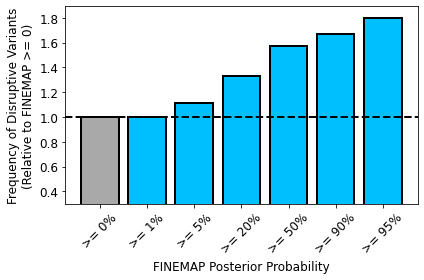

--- Fisher's exact test ---

x (low)  = 0.001
x (high) = 0.2

n (low)  = 1026
n (high) = 202

[[942.  84.]
 [179.  23.]]

(1.4409417398244213, 0.09330476285498879)

RanksumsResult(statistic=1.7953519202835833, pvalue=0.03629882382397424)

x_thresh_low = -0.4055


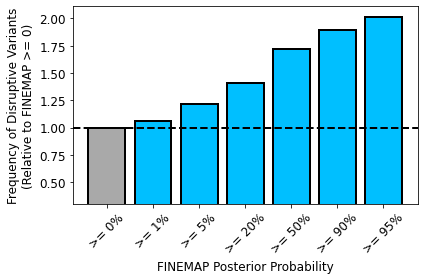

--- Fisher's exact test ---

x (low)  = 0.001
x (high) = 0.2

n (low)  = 1026
n (high) = 202

[[965.  61.]
 [183.  19.]]

(1.6424796201737883, 0.05238394717543503)

RanksumsResult(statistic=1.7953519202835833, pvalue=0.03629882382397424)

x_thresh_low = -0.6931


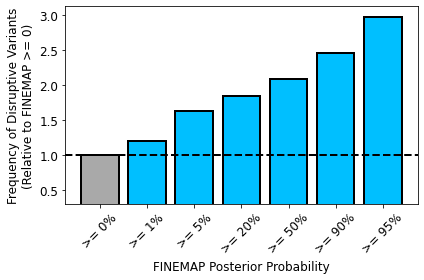

--- Fisher's exact test ---

x (low)  = 0.001
x (high) = 0.2

n (low)  = 1026
n (high) = 202

[[996.  30.]
 [190.  12.]]

(2.096842105263158, 0.03188941718410415)

RanksumsResult(statistic=1.7953519202835833, pvalue=0.03629882382397424)



In [8]:
#Calculate statistics in intervals of FINEMAP PP (log odds)

from scipy.stats import ranksums, fisher_exact

x = -np.abs(variant_df_gwas_all_lead.query("site_type == '3_most_exon' and native_usage > 0. and native_usage < 1.")['delta_logodds_0_205'].values)
y = np.array(variant_df_gwas_all_lead.query("site_type == '3_most_exon' and native_usage > 0. and native_usage < 1.")['FINEMAP'].values)

x_thresh_lows = [-np.log(1.4), -np.log(1.5), -np.log(2.0)]

fisher_test_low_y = 0.001
fisher_test_high_y = 0.2

for x_thresh_low in x_thresh_lows :

    print("x_thresh_low = " + str(round(x_thresh_low, 4)))
    
    x_0 = x[(y >= 0.)]
    x_0_01 = x[(y >= 0.01)]
    x_0_05 = x[(y >= 0.05)]
    x_0_2 = x[(y >= 0.2)]
    x_0_5 = x[(y >= 0.5)]
    x_0_9 = x[(y >= 0.9)]
    x_0_95 = x[(y >= 0.95)]

    f_0 = np.sum(x_0 < x_thresh_low) / x_0.shape[0]
    f_0_01 = np.sum(x_0_01 < x_thresh_low) / x_0_01.shape[0]
    f_0_05 = np.sum(x_0_05 < x_thresh_low) / x_0_05.shape[0]
    f_0_2 = np.sum(x_0_2 < x_thresh_low) / x_0_2.shape[0]
    f_0_5 = np.sum(x_0_5 < x_thresh_low) / x_0_5.shape[0]
    f_0_9 = np.sum(x_0_9 < x_thresh_low) / x_0_9.shape[0]
    f_0_95 = np.sum(x_0_95 < x_thresh_low) / x_0_95.shape[0]

    r_0_01 = f_0_01 / f_0
    r_0_05 = f_0_05 / f_0
    r_0_2 = f_0_2 / f_0
    r_0_5 = f_0_5 / f_0
    r_0_9 = f_0_9 / f_0
    r_0_95 = f_0_95 / f_0

    fs = np.array([1., r_0_01, r_0_05, r_0_2, r_0_5, r_0_9, r_0_95])

    f = plt.figure(figsize=(6, 4))

    plt.bar([0], [fs[0]], color='darkgray', linewidth=2, edgecolor='black')
    plt.bar((np.arange(fs.shape[0]-1)+1).tolist(), fs[1:].tolist(), color='deepskyblue', linewidth=2, edgecolor='black')

    plt.axhline(y=1.0, linewidth=2, linestyle='--', color='black')

    plt.xticks(
        np.arange(fs.shape[0]), [
            ">= 0%",
            ">= 1%",
            ">= 5%",
            ">= 20%",
            ">= 50%",
            ">= 90%",
            ">= 95%",
        ], fontsize=12, rotation=45
    )

    plt.yticks(fontsize=12)

    plt.xlabel("FINEMAP Posterior Probability", fontsize=12)
    plt.ylabel("Frequency of Disruptive Variants\n(Relative to FINEMAP >= 0)", fontsize=12)

    plt.ylim(0.3)

    plt.tight_layout()

    plt.savefig("apa_causaldb_disruptive_frequency_logodds_" + str(round(x_thresh_low, 4)).replace(".", "_").replace("-", "") + "_v2.eps")
    plt.savefig("apa_causaldb_disruptive_frequency_logodds_" + str(round(x_thresh_low, 4)).replace(".", "_").replace("-", "") + "_v2.png", transparent=True, dpi=300)

    plt.show()
    
    x_low = x[(y < fisher_test_low_y)]
    x_high = x[(y >= fisher_test_high_y)]

    print("--- Fisher's exact test ---")
    print("")
    print("x (low)  = " + str(fisher_test_low_y))
    print("x (high) = " + str(fisher_test_high_y))
    print("")
    print("n (low)  = " + str(x_low.shape[0]))
    print("n (high) = " + str(x_high.shape[0]))
    
    t1 = np.zeros((2, 2))
    
    t1[0, 0] = np.sum(x_low >= x_thresh_low)
    t1[0, 1] = np.sum(x_low < x_thresh_low)
    t1[1, 0] = np.sum(x_high >= x_thresh_low)
    t1[1, 1] = np.sum(x_high < x_thresh_low)

    print("")
    print(t1)
    print("")

    print(fisher_exact(t1, alternative='greater'))
    
    print("")
    
    print(ranksums(x_low, x_high, alternative='greater'))
    
    print("")
